Cleaning Data in Python

In [1]:
import pandas as pd

# Load raw datasets
orders = pd.read_csv("orders.csv")
deliveries = pd.read_csv("deliveries.csv")

# Remove duplicate orders
orders.drop_duplicates(subset=["order_id"], keep="first", inplace=True)

# Fill missing delivery_date where status is not 'Delivered'
deliveries.loc[(deliveries["status"] != "Delivered") & (deliveries["delivery_date"].isna()), "delivery_date"] = "Pending"

# Convert order_date to datetime
orders["order_date"] = pd.to_datetime(orders["order_date"])

# Prevent errors when converting "Pending" delivery_date
deliveries["delivery_date"] = pd.to_datetime(
    deliveries["delivery_date"], errors="coerce"
)  # Converts valid dates, leaves "Pending" as NaT

# Merge orders and deliveries to get order_date in deliveries DataFrame
deliveries = deliveries.merge(orders[["order_id", "order_date"]], on="order_id", how="left")

# Calculate delivery delay
def calculate_delay(row):
    if pd.isna(row["delivery_date"]):  # If it's "Pending" (NaT)
        return None  # Use None (or pd.NA) instead of a string
    else:
        return (row["delivery_date"] - row["order_date"]).days

deliveries["delivery_delay"] = deliveries.apply(calculate_delay, axis=1)

# Save cleaned datasets
orders.to_csv("orders_cleaned.csv", index=False)
deliveries.to_csv("deliveries_cleaned.csv", index=False)

print("Data cleaning complete. Cleaned files saved as 'orders_cleaned.csv' and 'deliveries_cleaned.csv'.")


Data cleaning complete. Cleaned files saved as 'orders_cleaned.csv' and 'deliveries_cleaned.csv'.


Python to SQLite

In [2]:
import sqlite3
import pandas as pd

# Connect to SQLite in-memory database
conn = sqlite3.connect(":memory:")

# Load cleaned data from Excel
orders = pd.read_csv("orders_cleaned.csv")
deliveries = pd.read_csv("deliveries_cleaned.csv")
warehouses = pd.read_csv("warehouses.csv")
customers = pd.read_csv("customers.csv")

# Load into SQLite
orders.to_sql("orders", conn, index=False, if_exists="replace")
deliveries.to_sql("deliveries", conn, index=False, if_exists="replace")
warehouses.to_sql("warehouses", conn, index=False, if_exists="replace")
customers.to_sql("customers", conn, index=False, if_exists="replace")

200

Queries

In [3]:
# Revenue by Region
query = """
SELECT region, SUM(total_amount) AS total_revenue
FROM (
    SELECT o.total_amount, c.region
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
) AS subquery
GROUP BY region
ORDER BY total_revenue DESC;
"""
pd.read_sql(query, conn)

,region,total_revenue
0,East,160022
1,West,142301
2,North,118929
3,South,110878


In [4]:
# Orders with delays over 5 days
query = """
SELECT order_id, order_date, delivery_date, status, 
       (JULIANDAY(delivery_date) - JULIANDAY(order_date)) AS delivery_delay
FROM deliveries
WHERE (JULIANDAY(delivery_date) - JULIANDAY(order_date)) > 5
  AND status = 'Delivered';
"""
pd.read_sql(query, conn)

,order_id,order_date,delivery_date,status,delivery_delay
0,5,2024-01-05,2024-01-13,Delivered,8.0
1,8,2024-01-08,2024-01-14,Delivered,6.0
2,15,2024-01-15,2024-01-21,Delivered,6.0
3,18,2024-01-18,2024-01-25,Delivered,7.0
4,19,2024-01-19,2024-01-27,Delivered,8.0
...,...,...,...,...,...
313,992,2026-09-18,2026-09-25,Delivered,7.0
314,996,2026-09-22,2026-10-01,Delivered,9.0
315,997,2026-09-23,2026-10-02,Delivered,9.0
316,998,2026-09-24,2026-09-30,Delivered,6.0


In [5]:
# Avg delay per warehouse in days
query = """
SELECT warehouse_name, avg_delay FROM (
    SELECT w.warehouse_name, AVG(JULIANDAY(d.delivery_date) - JULIANDAY(o.order_date)) AS avg_delay
    FROM orders o
    JOIN deliveries d ON o.order_id = d.order_id
    JOIN warehouses w ON o.warehouse_id = w.warehouse_id
    WHERE d.status = 'Delivered'
    GROUP BY w.warehouse_name
) AS subquery
ORDER BY avg_delay DESC
LIMIT 3;
"""
pd.read_sql(query, conn)

,warehouse_name,avg_delay
0,Warehouse_6,5.472222
1,Warehouse_10,5.441558
2,Warehouse_2,5.337662


In [6]:
# Cost of customer orders
query = """
SELECT customer_name, total_spent FROM (
    SELECT c.customer_name, SUM(o.total_amount) AS total_spent
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY c.customer_name
) AS subquery
ORDER BY total_spent DESC
LIMIT 5;
"""
pd.read_sql(query, conn)

,customer_name,total_spent
0,Customer_152,7444
1,Customer_113,7010
2,Customer_145,6797
3,Customer_161,6207
4,Customer_86,5575


In [7]:
# SQL query to find the fastest warehouses
fast_warehouses_query = """
SELECT warehouse_name, avg_delay
FROM (
    SELECT w.warehouse_name, AVG(JULIANDAY(d.delivery_date) - JULIANDAY(o.order_date)) AS avg_delay
    FROM orders o
    JOIN deliveries d ON o.order_id = d.order_id
    JOIN warehouses w ON o.warehouse_id = w.warehouse_id
    WHERE d.status = 'Delivered'
    GROUP BY w.warehouse_name
) AS subquery
ORDER BY avg_delay ASC  -- Sort by the fastest average delay
LIMIT 3;
"""

# Execute the query and store the result in a DataFrame
fast_warehouses = pd.read_sql(fast_warehouses_query, conn)

In [8]:
# Query for total revenue by region
revenue_by_region_query = """
SELECT region, SUM(total_amount) AS total_revenue 
FROM (
    SELECT o.total_amount, c.region 
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
) AS subquery 
GROUP BY region 
ORDER BY total_revenue DESC;
"""

# Query for slowest warehouses (top 3 with highest avg delay)
slow_warehouses_query = """
SELECT warehouse_name, avg_delay 
FROM (
    SELECT w.warehouse_name, AVG(JULIANDAY(d.delivery_date) - JULIANDAY(o.order_date)) AS avg_delay
    FROM orders o
    JOIN deliveries d ON o.order_id = d.order_id
    JOIN warehouses w ON o.warehouse_id = w.warehouse_id
    WHERE d.status = 'Delivered'
    GROUP BY w.warehouse_name
) AS subquery 
ORDER BY avg_delay DESC 
LIMIT 3;
"""

# Read SQL query results into Pandas DataFrames
revenue_by_region = pd.read_sql(revenue_by_region_query, conn)
slow_warehouses = pd.read_sql(slow_warehouses_query, conn)


In [9]:
print("Revenue by Region:")
print(revenue_by_region)

print("\nTop 3 Slowest Warehouses:")
print(slow_warehouses)

print("\nTop 3 Fastest Warehouses:")
print(fast_warehouses)

Revenue by Region:
  region  total_revenue
0   East         160022
1   West         142301
2  North         118929
3  South         110878

Top 3 Slowest Warehouses:
  warehouse_name  avg_delay
0    Warehouse_6   5.472222
1   Warehouse_10   5.441558
2    Warehouse_2   5.337662

Top 3 Fastest Warehouses:
  warehouse_name  avg_delay
0    Warehouse_8   4.439394
1    Warehouse_4   4.641791
2    Warehouse_1   4.842857


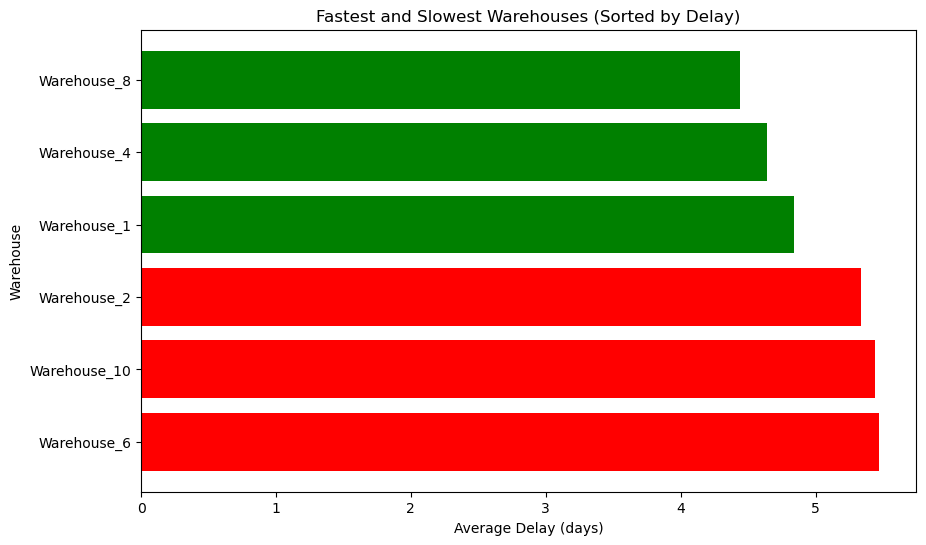

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming fast_warehouses and slow_warehouses are already loaded as DataFrames

# Add a column to identify the speed category (Fast/Slow)
fast_warehouses["category"] = "Fastest"
slow_warehouses["category"] = "Slowest"

# Combine both datasets
combined_warehouses = pd.concat([fast_warehouses, slow_warehouses])

# Sort the combined dataset by avg_delay (ascending order)
combined_warehouses = combined_warehouses.sort_values(by="avg_delay", ascending=True)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the warehouses with color coding for fast/slow
plt.barh(combined_warehouses["warehouse_name"], combined_warehouses["avg_delay"],
         color=combined_warehouses["category"].map({"Fastest": "green", "Slowest": "red"}))

# Add labels and title
plt.xlabel("Average Delay (days)")
plt.ylabel("Warehouse")
plt.title("Fastest and Slowest Warehouses (Sorted by Delay)")
plt.gca().invert_yaxis()  # Flip for better readability

# Show the plot
plt.show()


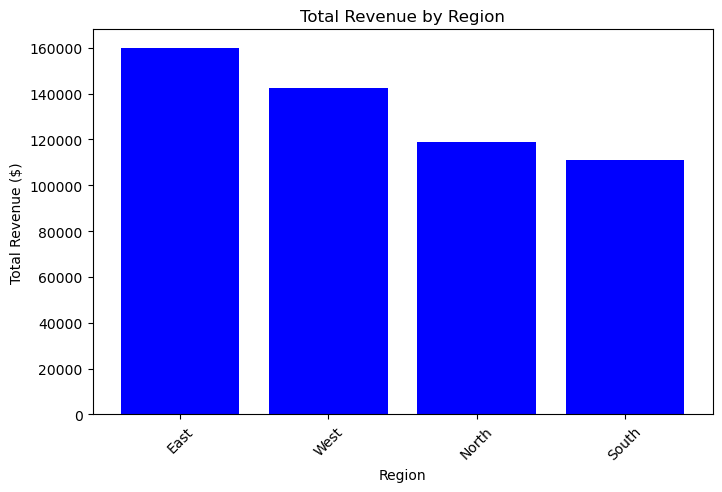

In [11]:
import matplotlib.pyplot as plt

# Plot revenue per region
plt.figure(figsize=(8, 5))
plt.bar(revenue_by_region["region"], revenue_by_region["total_revenue"], color="blue")
plt.xlabel("Region")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue by Region")
plt.xticks(rotation=45)
plt.show()